# Deep Learning Course Project - Gesture Recognition
### Problem Statement
Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.

The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:

                Gesture	Corresponding Action
                Thumbs Up   -Increase the volume.
                Thumbs Down -Decrease the volume.
                Left Swipe	-'Jump' backwards 10 seconds.
                Right Swipe	-'Jump' forward 10 seconds.
                Stop	    - Pause the movie.
Each video is a sequence of 30 frames (or images).

In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

### Objectives:
#### Generator:
The generator should be able to take a batch of videos as input without any error. Steps like cropping, resizing and normalization should be performed successfully.

#### Model:
Develop a model that is able to train without any errors which will be judged on the total number of parameters (as the inference(prediction) time should be less) and the accuracy achieved. As suggested by Snehansu, start training on a small amount of data and then proceed further.

#### Write up:
This should contain the detailed procedure followed in choosing the final model. The write up should start with the reason for choosing the base model, then highlight the reasons and metrics taken into consideration to modify and experiment to arrive at the final model.

In [1]:
import numpy as np
import os
import cv2
from skimage.transform import resize
import datetime
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, LSTM, Bidirectional, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout, Flatten, BatchNormalization, Activation, Conv3D, MaxPooling3D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow import keras
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In [3]:
#Below environment variable is set in order to run the code in both JARVIS and COLAB without changes
#environment = "JARVIS"
environment = "COLAB"

In [4]:
#Mount Google Drive
if environment == "COLAB":
  from google.colab import drive
  drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [7]:
#!unzip "/home/dl_content/Upgrad DL/Project_Data/Project_data.zip" > /dev/null
if environment == "COLAB":
  !unzip "/content/gdrive/MyDrive/DataSets/Project_data.zip" > /dev/null

In [8]:
#Define the path of CSV files provided for Train, Validation
#In this block, we read the folder names for training and validation
if environment == "COLAB":
  train_doc = np.random.permutation(open('/content/Project_data/train.csv').readlines())
  val_doc = np.random.permutation(open('/content/Project_data/val.csv').readlines())
elif environment == "JARVIS":
  train_doc = np.random.permutation(open('datasets/Project_data/train.csv').readlines())
  val_doc = np.random.permutation(open('datasets/Project_data/val.csv').readlines())
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

# training sequences = 663
# validation sequences = 100


In [9]:
if environment == "COLAB":
  Proj_data_dir="/content/Project_data"
elif environment == "JARVIS":
  Proj_data_dir = "datasets/Project_data/"

In [10]:
#Define the path
train_path = Proj_data_dir + '/' + 'train'
val_path =  Proj_data_dir + '/' + 'val'

In [11]:
#API for cropping image
def crop_center(image, crop_width, crop_height):
    img_width, img_height = image.size
    return image.crop(((img_width - crop_width) // 2,
                         (img_height - crop_height) // 2,
                         (img_width + crop_width) // 2,
                         (img_height + crop_height) // 2))
def crop_max_square(image):
    return crop_center(image, min(image.size), min(image.size))

In [12]:
#Implementation to handle last batch (if the number of images in last batch < batch size)
def process_batch_data(source_path,t,batch,img_idx,remaining_seq=0,augment_data=False):
    # we iterate over the number of batches
    # for batch in range(num_batches)x is the number of images (len(img_idx)) used for each video
    # (y,z) is the final size (height & width) of the input images and 3 is the number of channels RGB
    seq_len = remaining_seq if remaining_seq else batch_size

    batch_data = np.zeros((seq_len,len(img_idx),img_y,img_z,3))
    batch_labels = np.zeros((seq_len,5))

    for folder in range(seq_len): # iterate over the batch_size
        # read all the images in the folder
        imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])
        for idx,item in enumerate(img_idx):
            #  Iterate over the frames/images of a folder to read them in
            image = Image.open(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item])

            #Crop the images, if the hieght, width are different
            if image.width > image.height:
              image = crop_max_square(image)
            elif image.height > image.width:
              image = crop_max_square(image)

            resized_image = image.resize((img_y,img_z))
            resized_img_arr = np.array(resized_image).astype('float32')
            # Normalize the images
            batch_data[folder,idx,:,:,0] = (resized_img_arr[:,:,0])/255
            batch_data[folder,idx,:,:,1] = (resized_img_arr[:,:,1])/255
            batch_data[folder,idx,:,:,2] = (resized_img_arr[:,:,2])/255
            #crop the images and resize them. Note that the images are of 2 different shape

        #print(folder)
        #print(t[folder + (batch*model_params.batch_size)])
        batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1

    #print("batch_labels::",batch_labels)
    return(batch_data,batch_labels)

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `height`,`width` and normalization such that you get high accuracy.

In [13]:
#Generator API
def generator(source_path, folder_list,batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    #create a list of image numbers you want to use for a particular video
    img_idx = np.round(np.linspace(0,29,frame_count)).astype(int)
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size
        #Below code is to run the full batches
        for batch in range(num_batches):
            batch_data, batch_labels= process_batch_data(source_path,t,batch,img_idx,0)
            yield batch_data, batch_labels
        # write the code for the remaining data points which are left after full batches
        remaining_imgs = len(t)%batch_size

        if (remaining_imgs != 0):
            batch_data, batch_labels= process_batch_data(source_path,t,num_batches,img_idx,remaining_imgs)
            yield batch_data, batch_labels

In [ ]:
# testing generative
# frame_count = 10
# img_y =160
# img_z =160
# test_gen = generator(train_path, train_doc, 1)
# d = next(test_gen)[0]

Source path =  /content/Project_data/train ; batch size = 1


In [17]:
def model_train_fit(model,train_path,train_doc,val_path, val_doc,batch_size,frame_count,img_y,img_z,num_train_sequences,num_val_sequences,num_epochs):
    #creates  train_generator and  val_generator which will be used in .fit_generator.
    train_generator = generator(train_path, train_doc, batch_size)
    val_generator = generator(val_path, val_doc, batch_size)

    model_name = '/content/gdrive/MyDrive/GR_best/Gesture_recog' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

    if not os.path.exists(model_name):
        os.mkdir(model_name)


    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'

    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')

    LR = ReduceLROnPlateau(monitor = "val_loss", factor = 0.2, patience = 3,verbose = 1)
    callbacks_list = [checkpoint, LR]

    #The `steps_per_epoch` and `validation_steps` are used by `fit` method to decide the number of next() calls it need to make.

    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1

    #Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.
    #The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

    history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                        callbacks=callbacks_list, validation_data=val_generator,
                        validation_steps=validation_steps, class_weight=None, workers=1,initial_epoch=0)
    return history

In [15]:
#API to plot the model performance details
def plot_model(history,epochs):
  train_acc = history.history['categorical_accuracy']
  val_acc = history.history['val_categorical_accuracy']

  train_loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, train_acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, train_loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

In [16]:
curr_dt_time = datetime.datetime.now()
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 15# choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 15


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.



```
# This is formatted as code
```

### Base Conv3D Model_1

In [ ]:
# Model is defined with 4 3D-Convolution layers with BatchNormalization ,MaxPooling with "relu"
# followed by 2 Dense layers one Dense layer uses "relu"  activation and "softmax" for output for the different categories
def define_model(Input_shape,dropout=0.2,dense_neurons=128):
    model = Sequential()

    #1st 3D Convolution layer
    model.add(Conv3D(16, (2,2,2), padding='same',input_shape=Input_shape))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    # 2nd Convolution layer
    model.add(Conv3D(32, (2,2,2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2,2,2)))

    # 3rd Convolution layer
    model.add(Conv3D(64, (2,2,2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2,2,2)))

    # 4th Convolution layer
    model.add(Conv3D(128, (2,2,2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2,2,2)))

    # Flatten
    model.add(Flatten())

    #Dense
    model.add(Dense(dense_neurons,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    # No of Categories are 5
    model.add(Dense(5,activation='softmax'))

    #Model compilation,
    optimiser = optimizers.Adam()
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

    return model

In [ ]:
#Print the summary of the model, we will see the total number of parameters you have to train.
frame_count=30
img_y =160
img_z =160
num_epochs = 10
Input_shape = (frame_count, img_y, img_z, 3)
model_1 = define_model(Input_shape)
batch_size = 32
print (model_1.summary())

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 30, 160, 160, 16   400       
                             )                                   
                                                                 
 activation (Activation)     (None, 30, 160, 160, 16   0         
                             )                                   
                                                                 
 batch_normalization_41 (Ba  (None, 30, 160, 160, 16   64        
 tchNormalization)           )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 15, 80, 80, 16)    0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 15, 80, 80, 32)   

This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [ ]:
history1 = model_train_fit(model_1,train_path,train_doc,val_path, val_doc,batch_size,
                      frame_count,img_y,img_z,num_train_sequences,num_val_sequences,num_epochs)

Source path =  /content/Project_data/train ; batch size = 32
Epoch 1/10
21/21 [==============================] - ETA: 0s - loss: 1.1832 - categorical_accuracy: 0.5822Source path =  /content/Project_data/val ; batch size = 32

Epoch 1: saving model to Gesture_recog_2024-05-0106_34_30.340110/model-00001-1.18325-0.58220-5.20891-0.21000.keras
21/21 [==============================] - 119s 5s/step - loss: 1.1832 - categorical_accuracy: 0.5822 - val_loss: 5.2089 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/10
21/21 [==============================] - ETA: 0s - loss: 0.3953 - categorical_accuracy: 0.8597
Epoch 2: saving model to Gesture_recog_2024-05-0106_34_30.340110/model-00002-0.39532-0.85973-8.35479-0.17000.keras
21/21 [==============================] - 102s 5s/step - loss: 0.3953 - categorical_accuracy: 0.8597 - val_loss: 8.3548 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 3/10
21/21 [==============================] - ETA: 0s - loss: 0.1752 - categorical_accuracy: 0.953

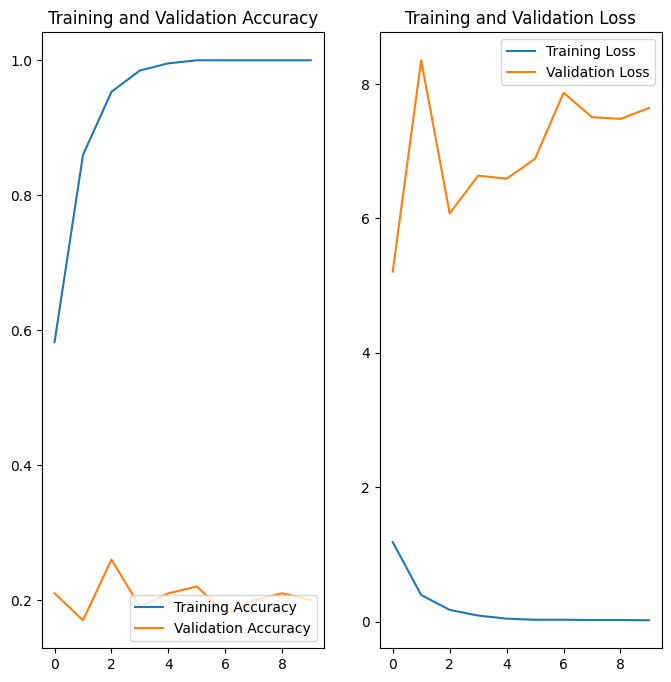

In [ ]:
plot_model(history1,num_epochs)

Observation: Model is Overfitting, Lets decrease the frames and resize the image, to increase the overall accuracy

### Conv3D Model_2
 Reducing number of frames to  20 and image size to 120*120 and batch size = 20

In [ ]:
frame_count=25
img_y =120
img_z =120
num_epochs = 10
Input_shape = (frame_count, img_y, img_z, 3)
batch_size = 20
model_2 = define_model(Input_shape)
print (model_2.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 25, 120, 120, 16)  400       
                                                                 
 activation_12 (Activation)  (None, 25, 120, 120, 16)  0         
                                                                 
 batch_normalization_15 (Bat  (None, 25, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 12, 60, 60, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_13 (Conv3D)          (None, 12, 60, 60, 32)    4128      
                                                                 
 activation_13 (Activation)  (None, 12, 60, 60, 32)   

In [ ]:
history2 = model_train_fit(model_2,train_path,train_doc,val_path, val_doc,batch_size,
                      frame_count,img_y,img_z,num_train_sequences,num_val_sequences,num_epochs)

Source path =  datasets/Project_data/train ; batch size = 20
Epoch 1/10
34/34 [==============================] - ETA: 0s - loss: 1.1451 - categorical_accuracy: 0.5505Source path =  datasets/Project_data/val ; batch size = 20

Epoch 00001: saving model to Gesture_recog_2024-04-3011_56_25.410900/model-00001-1.14509-0.55053-4.25467-0.16000.h5
34/34 [==============================] - 127s 4s/step - loss: 1.1451 - categorical_accuracy: 0.5505 - val_loss: 4.2547 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/10
34/34 [==============================] - ETA: 0s - loss: 1.2502 - categorical_accuracy: 0.5098
Epoch 00002: saving model to Gesture_recog_2024-04-3011_56_25.410900/model-00002-1.25016-0.50980-5.21575-0.17000.h5
34/34 [==============================] - 33s 1s/step - loss: 1.2502 - categorical_accuracy: 0.5098 - val_loss: 5.2158 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 3/10
34/34 [==============================] - ETA: 0s - loss: 1.2687 - categorical_accuracy: 0.50

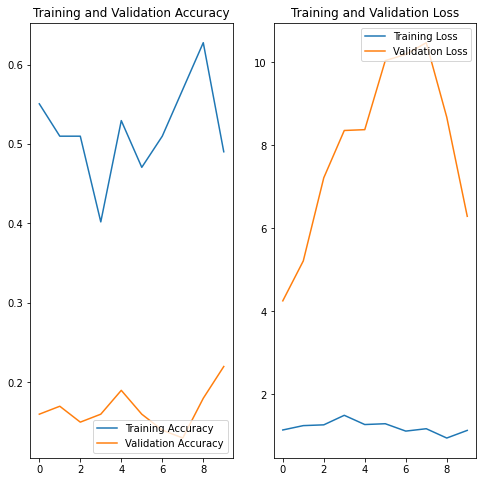

In [ ]:
plot_model(history2,num_epochs)

Observation:Still overfitting, as well as the model training accuracy reduced as compare to base model.

### Conv3D Model_3
Increaing Dropout % to 0.4 from 0.2 and increaing image size back to 160*160

In [ ]:
frame_count=20
img_y =160
img_z =160
Input_shape = (frame_count, img_y, img_z, 3)
model_3 = define_model(Input_shape,0.40)
num_epochs = 15
batch_size = 25
print (model_3.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_16 (Conv3D)          (None, 20, 160, 160, 16)  400       
                                                                 
 activation_16 (Activation)  (None, 20, 160, 160, 16)  0         
                                                                 
 batch_normalization_20 (Bat  (None, 20, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_16 (MaxPoolin  (None, 10, 80, 80, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_17 (Conv3D)          (None, 10, 80, 80, 32)    4128      
                                                                 
 activation_17 (Activation)  (None, 10, 80, 80, 32)   

In [ ]:
history3 = model_train_fit(model_3,train_path,train_doc,val_path, val_doc,batch_size,
                      frame_count,img_y,img_z,num_train_sequences,num_val_sequences,num_epochs)

Source path =  datasets/Project_data/train ; batch size = 25
Epoch 1/15
27/27 [==============================] - ETA: 0s - loss: 1.3345 - categorical_accuracy: 0.5158Source path =  datasets/Project_data/val ; batch size = 25

Epoch 00001: saving model to Gesture_recog_2024-04-3011_56_25.410900/model-00001-1.33448-0.51584-2.76400-0.16000.h5
27/27 [==============================] - 108s 4s/step - loss: 1.3345 - categorical_accuracy: 0.5158 - val_loss: 2.7640 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/15
27/27 [==============================] - ETA: 0s - loss: 0.7522 - categorical_accuracy: 0.6980
Epoch 00002: saving model to Gesture_recog_2024-04-3011_56_25.410900/model-00002-0.75219-0.69801-4.58655-0.16000.h5
27/27 [==============================] - 65s 2s/step - loss: 0.7522 - categorical_accuracy: 0.6980 - val_loss: 4.5866 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 3/15
27/27 [==============================] - ETA: 0s - loss: 0.6425 - categorical_accuracy: 0.76

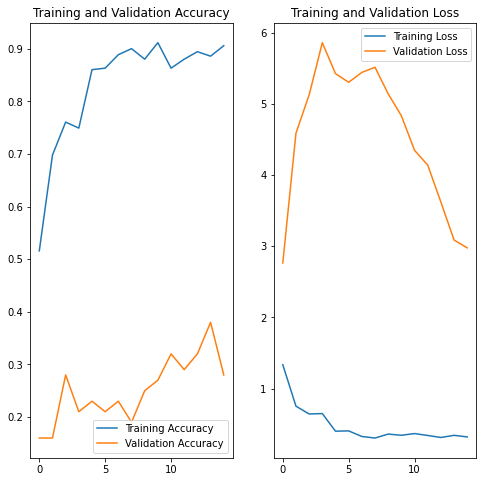

In [ ]:
plot_model(history3,num_epochs)

Observation:Model is still Overfitting.

### CON3D Model_4
Increasing number of neurons in Dense layer and also applying explicit LR instead of default LR

In [ ]:
frame_count=20
img_y =130
img_z =130
Input_shape = (frame_count, img_y, img_z, 3)
model_4 = define_model(Input_shape,0.40,256)
num_epochs = 20
batch_size = 20
print (model_4.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_20 (Conv3D)          (None, 20, 130, 130, 16)  400       
                                                                 
 activation_20 (Activation)  (None, 20, 130, 130, 16)  0         
                                                                 
 batch_normalization_25 (Bat  (None, 20, 130, 130, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_20 (MaxPoolin  (None, 10, 65, 65, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_21 (Conv3D)          (None, 10, 65, 65, 32)    4128      
                                                                 
 activation_21 (Activation)  (None, 10, 65, 65, 32)   

In [ ]:
#explitly changing learning rate
optimiser = optimizers.Adam(learning_rate = 0.0003)#write your optimizer
model_4.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [ ]:
history4 = model_train_fit(model_4,train_path,train_doc,val_path, val_doc,batch_size,
                      frame_count,img_y,img_z,num_train_sequences,num_val_sequences,num_epochs)

Source path =  datasets/Project_data/train ; batch size = 20
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.4295 - categorical_accuracy: 0.5219Source path =  datasets/Project_data/val ; batch size = 20

Epoch 00001: saving model to Gesture_recog_2024-04-3011_56_25.410900/model-00001-1.42948-0.52187-3.77361-0.16000.h5
34/34 [==============================] - 117s 3s/step - loss: 1.4295 - categorical_accuracy: 0.5219 - val_loss: 3.7736 - val_categorical_accuracy: 0.1600 - lr: 3.0000e-04
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 0.8861 - categorical_accuracy: 0.6961
Epoch 00002: saving model to Gesture_recog_2024-04-3011_56_25.410900/model-00002-0.88608-0.69608-6.40365-0.14000.h5
34/34 [==============================] - 29s 881ms/step - loss: 0.8861 - categorical_accuracy: 0.6961 - val_loss: 6.4036 - val_categorical_accuracy: 0.1400 - lr: 3.0000e-04
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 1.0965 - categorical_acc

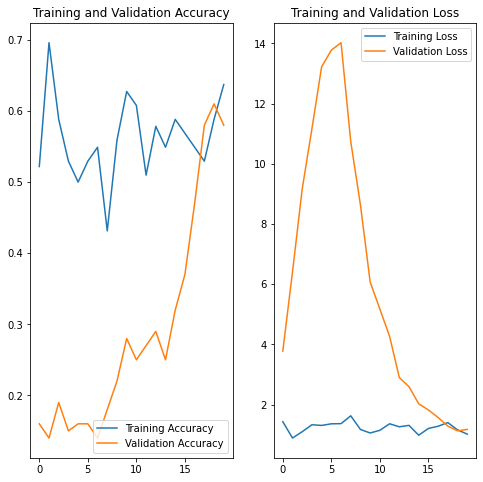

In [ ]:
plot_model(history4,num_epochs)

Observation:Seen improvement but sill the accuracy can improve with good fit. Next trying ConvLSTM to see if we get better results

### Conv2D RNN + LSTM Model_5

1.   List item


In [ ]:

def define_conv2d_model(Input_shape,drop_out=0.25,neurons=128):
    model = Sequential()
    #1st Layer
    model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                              input_shape=Input_shape))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    #2nd Layer
    model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    #3rd Layer
    model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    #4th Layer
    model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    #5th Layer
    model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    #Flatten layer
    model.add(TimeDistributed(Flatten()))

    #LSTM
    model.add(LSTM(neurons))
    model.add(Dropout(drop_out))

    model.add(Dense(neurons, activation='relu'))
    model.add(Dropout(drop_out))

    model.add(Dense(5, activation='softmax'))

    optimiser = optimizers.Adam()#write your optimizer
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

    return model

In [ ]:
frame_count=20
batch_size= 20
img_y =120
img_z =120
num_epochs = 15
Input_shape = (frame_count, img_y, img_z, 3)
convd2_model_1 = define_conv2d_model(Input_shape)
print (convd2_model_1.summary())

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_132 (Time  (None, 20, 120, 120, 16   448       
 Distributed)                )                                   
                                                                 
 time_distributed_133 (Time  (None, 20, 120, 120, 16   64        
 Distributed)                )                                   
                                                                 
 time_distributed_134 (Time  (None, 20, 60, 60, 16)    0         
 Distributed)                                                    
                                                                 
 time_distributed_135 (Time  (None, 20, 60, 60, 32)    4640      
 Distributed)                                                    
                                                                 
 time_distributed_136 (Time  (None, 20, 60, 60, 32)  

In [ ]:
history_conv2d_1 = model_train_fit(convd2_model_1,train_path,train_doc,val_path, val_doc,batch_size,
                      frame_count,img_y,img_z,num_train_sequences,num_val_sequences,num_epochs)

Source path =  /content/Project_data/train ; batch size = 20
Epoch 1/15
33/34 [============================>.] - ETA: 1s - loss: 1.3842 - categorical_accuracy: 0.4091Source path =  /content/Project_data/val ; batch size = 20

Epoch 1: saving model to Gesture_recog_2024-05-0106_34_30.340110/model-00001-1.38267-0.41176-1.80851-0.24000.keras
34/34 [==============================] - 60s 2s/step - loss: 1.3827 - categorical_accuracy: 0.4118 - val_loss: 1.8085 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 2/15
34/34 [==============================] - ETA: 0s - loss: 1.0696 - categorical_accuracy: 0.5460
Epoch 2: saving model to Gesture_recog_2024-05-0106_34_30.340110/model-00002-1.06961-0.54600-2.56983-0.21000.keras
34/34 [==============================] - 48s 1s/step - loss: 1.0696 - categorical_accuracy: 0.5460 - val_loss: 2.5698 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 3/15
33/34 [============================>.] - ETA: 1s - loss: 0.9914 - categorical_accuracy: 0.6167


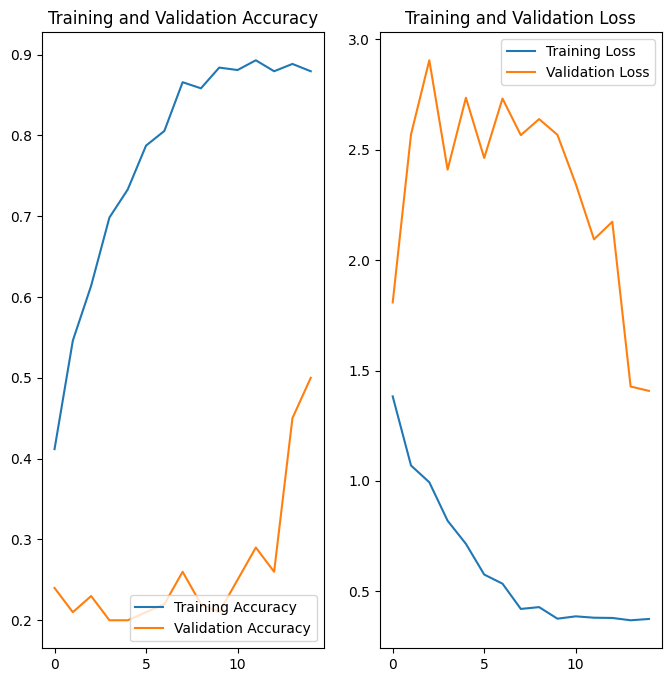

In [ ]:
plot_model(history_conv2d_1,15)

Observation: Model is overfitting, next trying increase with the increase in image resolution and number of epochs

### Conv2D RNN + LSTM Model_6
With more number of epochs - 25

In [ ]:
#Finding optimal frame_count and hyper parameters
frame_count=20
batch_size=20
img_y =120
img_z =120
num_epochs = 25
Input_shape = (frame_count, img_y, img_z, 3)
convd2_model_2 = define_conv2d_model(Input_shape)
print (convd2_model_2.summary())

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_148 (Time  (None, 20, 120, 120, 16   448       
 Distributed)                )                                   
                                                                 
 time_distributed_149 (Time  (None, 20, 120, 120, 16   64        
 Distributed)                )                                   
                                                                 
 time_distributed_150 (Time  (None, 20, 60, 60, 16)    0         
 Distributed)                                                    
                                                                 
 time_distributed_151 (Time  (None, 20, 60, 60, 32)    4640      
 Distributed)                                                    
                                                                 
 time_distributed_152 (Time  (None, 20, 60, 60, 32)  

In [ ]:
history_conv2d_2 = model_train_fit(convd2_model_2,train_path,train_doc,val_path, val_doc,batch_size,
                      frame_count,img_y,img_z,num_train_sequences,num_val_sequences,num_epochs)

Source path =  /content/Project_data/train ; batch size = 20
Epoch 1/25
33/34 [============================>.] - ETA: 1s - loss: 1.4082 - categorical_accuracy: 0.3939Source path =  /content/Project_data/val ; batch size = 20

Epoch 1: saving model to Gesture_recog_2024-05-0106_34_30.340110/model-00001-1.40538-0.39517-1.78517-0.21000.keras
34/34 [==============================] - 56s 1s/step - loss: 1.4054 - categorical_accuracy: 0.3952 - val_loss: 1.7852 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.1565 - categorical_accuracy: 0.5415
Epoch 2: saving model to Gesture_recog_2024-05-0106_34_30.340110/model-00002-1.15646-0.54148-2.42522-0.22000.keras
34/34 [==============================] - 45s 1s/step - loss: 1.1565 - categorical_accuracy: 0.5415 - val_loss: 2.4252 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 3/25
33/34 [============================>.] - ETA: 1s - loss: 1.0147 - categorical_accuracy: 0.6045


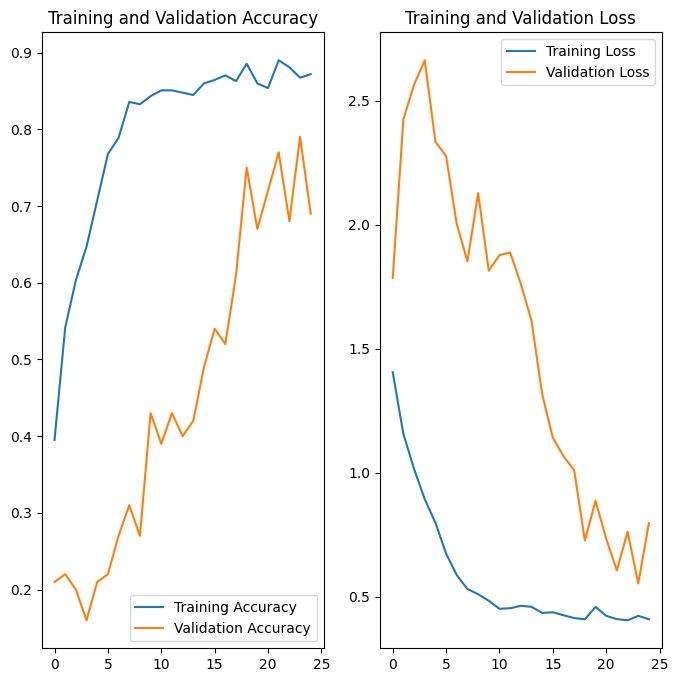

In [ ]:
plot_model(history_conv2d_2,25)

Observation: Model validation accuracy improved as compare to previous model,But next trying increase GRU to furture improve the validation accuracy.

### Conv2D RNN + GRU Model_7

In [ ]:
def define_conv2d_GRU_model(Input_shape, gru_cells=64, dense_neurons=64,drop_out=0.25):
    model = Sequential()
    #1st Layer
    model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                              input_shape=Input_shape))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    #2nd Layer
    model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    #3rd Layer
    model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    #4th Layer
    model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    #5th Layer
    model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Flatten()))

    model.add(GRU(gru_cells))
    model.add(Dropout(drop_out))

    model.add(Dense(dense_neurons,activation='relu'))
    model.add(Dropout(drop_out))

    model.add(Dense(5, activation='softmax'))


    optimiser = optimizers.Adam()#write your optimizer
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

    return model

In [ ]:
#Finding optimal frame_count and hyper parameters
frame_count=20
batch_size=20
img_y =120
img_z =120
num_epochs = 25
Input_shape = (frame_count, img_y, img_z, 3)
convd2_model_GRU = define_conv2d_GRU_model(Input_shape, 128, 128,0.25)
print (convd2_model_GRU.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_80 (TimeD  (None, 20, 120, 120, 16   448       
 istributed)                 )                                   
                                                                 
 time_distributed_81 (TimeD  (None, 20, 120, 120, 16   64        
 istributed)                 )                                   
                                                                 
 time_distributed_82 (TimeD  (None, 20, 60, 60, 16)    0         
 istributed)                                                     
                                                                 
 time_distributed_83 (TimeD  (None, 20, 60, 60, 32)    4640      
 istributed)                                                     
                                                                 
 time_distributed_84 (TimeD  (None, 20, 60, 60, 32)   

In [ ]:
history_conv2d_GRU = model_train_fit(convd2_model_GRU,train_path,train_doc,val_path, val_doc,batch_size,
                      frame_count,img_y,img_z,num_train_sequences,num_val_sequences,num_epochs)

Source path =  /content/Project_data/train ; batch size = 20
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.3949 - categorical_accuracy: 0.4057Source path =  /content/Project_data/val ; batch size = 20

Epoch 1: saving model to Gesture_recog_2024-05-0106_34_30.340110/model-00001-1.39492-0.40573-2.34394-0.21000.keras
34/34 [==============================] - 55s 1s/step - loss: 1.3949 - categorical_accuracy: 0.4057 - val_loss: 2.3439 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/25
33/34 [============================>.] - ETA: 1s - loss: 1.0493 - categorical_accuracy: 0.5591
Epoch 2: saving model to Gesture_recog_2024-05-0106_34_30.340110/model-00002-1.04715-0.55958-2.35796-0.29000.keras
34/34 [==============================] - 47s 1s/step - loss: 1.0471 - categorical_accuracy: 0.5596 - val_loss: 2.3580 - val_categorical_accuracy: 0.2900 - lr: 0.0010
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 0.8270 - categorical_accuracy: 0.6878


Observation as per above model we are getting good training accuracy but not the good val accuracy

### Conv2D RNN + GRU Model_8
Increased dropout % it was slightly overfitting in the previous GRU model



In [ ]:
#Finding optimal frame_count and hyper parameters
frame_count=20
batch_size=20
img_y =120
img_z =120
num_epochs = 25
Input_shape = (frame_count, img_y, img_z, 3)
convd2_model_GRU2 = define_conv2d_GRU_model(Input_shape, 128, 128,0.35)
print (convd2_model_GRU2.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_96 (TimeD  (None, 20, 120, 120, 16   448       
 istributed)                 )                                   
                                                                 
 time_distributed_97 (TimeD  (None, 20, 120, 120, 16   64        
 istributed)                 )                                   
                                                                 
 time_distributed_98 (TimeD  (None, 20, 60, 60, 16)    0         
 istributed)                                                     
                                                                 
 time_distributed_99 (TimeD  (None, 20, 60, 60, 32)    4640      
 istributed)                                                     
                                                                 
 time_distributed_100 (Time  (None, 20, 60, 60, 32)   

In [ ]:
history_conv2d_GRU2 = model_train_fit(convd2_model_GRU2,train_path,train_doc,val_path, val_doc,batch_size,
                      frame_count,img_y,img_z,num_train_sequences,num_val_sequences,num_epochs)

Source path =  /content/Project_data/train ; batch size = 20
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.5021 - categorical_accuracy: 0.3680Source path =  /content/Project_data/val ; batch size = 20

Epoch 1: saving model to Gesture_recog_2024-05-0106_34_30.340110/model-00001-1.50206-0.36802-2.14337-0.22000.keras
34/34 [==============================] - 58s 2s/step - loss: 1.5021 - categorical_accuracy: 0.3680 - val_loss: 2.1434 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 2/25
33/34 [============================>.] - ETA: 1s - loss: 1.2007 - categorical_accuracy: 0.5182
Epoch 2: saving model to Gesture_recog_2024-05-0106_34_30.340110/model-00002-1.19987-0.51735-2.41939-0.16000.keras
34/34 [==============================] - 47s 1s/step - loss: 1.1999 - categorical_accuracy: 0.5173 - val_loss: 2.4194 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.0081 - categorical_accuracy: 0.6063


Observations : Validation accuracy need to improve

### Conv2D RNN + GRU Model_9

In [ ]:
#Finding optimal frame_count and hyper parameters
frame_count=18
batch_size=20
img_y =120
img_z =120
num_epochs = 25
Input_shape = (frame_count, img_y, img_z, 3)
convd2_model_GRU3 = define_conv2d_GRU_model(Input_shape, 128, 128,0.35)
print (convd2_model_GRU3.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_112 (Time  (None, 18, 120, 120, 16   448       
 Distributed)                )                                   
                                                                 
 time_distributed_113 (Time  (None, 18, 120, 120, 16   64        
 Distributed)                )                                   
                                                                 
 time_distributed_114 (Time  (None, 18, 60, 60, 16)    0         
 Distributed)                                                    
                                                                 
 time_distributed_115 (Time  (None, 18, 60, 60, 32)    4640      
 Distributed)                                                    
                                                                 
 time_distributed_116 (Time  (None, 18, 60, 60, 32)   

In [ ]:
history_conv2d_GRU3 = model_train_fit(convd2_model_GRU3,train_path,train_doc,val_path, val_doc,batch_size,
                      frame_count,img_y,img_z,num_train_sequences,num_val_sequences,num_epochs)

Source path =  /content/Project_data/train ; batch size = 20
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.5416 - categorical_accuracy: 0.3454Source path =  /content/Project_data/val ; batch size = 20

Epoch 1: saving model to Gesture_recog_2024-05-0106_34_30.340110/model-00001-1.54157-0.34540-2.25207-0.18000.keras
34/34 [==============================] - 61s 2s/step - loss: 1.5416 - categorical_accuracy: 0.3454 - val_loss: 2.2521 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 2/25
33/34 [============================>.] - ETA: 0s - loss: 1.1771 - categorical_accuracy: 0.5015
Epoch 2: saving model to Gesture_recog_2024-05-0106_34_30.340110/model-00002-1.17907-0.50075-2.16908-0.25000.keras
34/34 [==============================] - 43s 1s/step - loss: 1.1791 - categorical_accuracy: 0.5008 - val_loss: 2.1691 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.0402 - categorical_accuracy: 0.5837


Observation : Model is still overfitting, as compared to previous model categorical accracy is reduced.

### GRU + MobileNet Model_10
Transfer learning

In [18]:
from tensorflow.keras.applications import mobilenet

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

def model_gru_mobilenet(Input_shape,gru_cells=64,dense_neurons=64,dropout=0.25):

    model = Sequential()
    model.add(TimeDistributed(mobilenet_transfer,input_shape=Input_shape))


    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Flatten()))

    model.add(GRU(gru_cells))
    model.add(Dropout(dropout))

    model.add(Dense(dense_neurons,activation='relu'))
    model.add(Dropout(dropout))

    model.add(Dense(5, activation='softmax'))


    optimiser = optimizers.Adam()
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model

17225924/17225924 [==============================] - 2s 0us/step


In [19]:
frame_count=16
img_y =120
img_z =120
batch_size=5
num_epochs=20
Input_shape = (frame_count, img_y, img_z, 3)
model_mobilenet= model_gru_mobilenet(Input_shape)
print (model_mobilenet.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 16, 3, 3, 1024)    3228864   
 ributed)                                                        
                                                                 
 time_distributed_1 (TimeDi  (None, 16, 3, 3, 1024)    4096      
 stributed)                                                      
                                                                 
 time_distributed_2 (TimeDi  (None, 16, 1, 1, 1024)    0         
 stributed)                                                      
                                                                 
 time_distributed_3 (TimeDi  (None, 16, 1024)          0         
 stributed)                                                      
                                                                 
 gru (GRU)                   (None, 64)                2

In [20]:
history_transfer = model_train_fit(model_mobilenet,train_path,train_doc,val_path, val_doc,batch_size,frame_count,img_y,img_z,num_train_sequences,num_val_sequences,num_epochs)

Source path =  /content/Project_data/train ; batch size = 5
Epoch 1/20
133/133 [==============================] - ETA: 0s - loss: 1.4183 - categorical_accuracy: 0.3665Source path =  /content/Project_data/val ; batch size = 5

Epoch 1: val_loss improved from inf to 0.93025, saving model to /content/gdrive/MyDrive/GR_best/Gesture_recog_2024-05-0111_17_02.005883/model-00001-1.41830-0.36652-0.93025-0.61000.keras
133/133 [==============================] - 66s 333ms/step - loss: 1.4183 - categorical_accuracy: 0.3665 - val_loss: 0.9302 - val_categorical_accuracy: 0.6100 - lr: 0.0010
Epoch 2/20
133/133 [==============================] - ETA: 0s - loss: 1.1048 - categorical_accuracy: 0.5611
Epoch 2: val_loss improved from 0.93025 to 0.61945, saving model to /content/gdrive/MyDrive/GR_best/Gesture_recog_2024-05-0111_17_02.005883/model-00002-1.10480-0.56109-0.61945-0.80000.keras
133/133 [==============================] - 42s 320ms/step - loss: 1.1048 - categorical_accuracy: 0.5611 - val_loss: 0.6

Observition : We are getting good categorical and validation accuracy.

#### Conclusion:

The Model built with Time distributed Conv2D and ConvLSTM2D gave better results compared to all the other Conv3D models and also the model has very least number of parameters compared to other models.
As per the above experiment we have decided to go with CNN-RNN Transferred Learning (GRU) model because it gives the best accuracy as compared to any other model that have been trained.
